In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
import warnings
import json
import os
import random


warnings.filterwarnings("ignore")

In [9]:
grid_df = pd.read_csv("my_data/grid_rot_my_data.csv")

In [10]:
grid_df.head(10)

,annotation_id,annotator,created_at,id,image,label,lead_time,updated_at
0,493,1,2023-09-03T14:58:37.655167Z,480,/data/upload/4/94c24d87-photo_2023-09-03_13-40...,"[{""x"":39.1434812919826,""y"":48.413256707242844,...",260.170,2023-09-04T10:36:25.479202Z
1,494,1,2023-09-03T15:01:42.912543Z,481,/data/upload/4/9c03a98d-photo_2023-09-03_13-40...,"[{""x"":24.44575773359399,""y"":34.847049492305736...",269.232,2023-09-04T10:37:38.537202Z
2,495,1,2023-09-03T15:11:11.972669Z,482,/data/upload/4/cd09385a-photo_2023-09-03_13-40...,"[{""x"":10.312528189020165,""y"":48.72280454045755...",752.754,2023-09-04T10:40:46.202676Z
3,496,1,2023-09-03T15:14:02.907984Z,483,/data/upload/4/f24461f0-photo_2023-09-03_13-40...,"[{""x"":39.57168197261703,""y"":48.57680570620522,...",265.889,2023-09-04T10:41:52.305109Z
4,497,1,2023-09-03T15:18:22.427193Z,484,/data/upload/4/da79a76d-photo_2023-09-03_13-40...,"[{""x"":25.148709196211072,""y"":34.53333333333302...",337.472,2023-09-04T10:42:55.717627Z
5,498,1,2023-09-03T15:20:56.460853Z,485,/data/upload/4/10f84da2-photo_2023-09-03_13-40...,"[{""x"":18.25963320837775,""y"":50.09104422024024,...",224.475,2023-09-04T10:43:57.749914Z
6,499,1,2023-09-03T15:24:25.293128Z,486,/data/upload/4/c394ce20-photo_2023-09-03_13-40...,"[{""x"":40.17526535328442,""y"":24.89282577553131,...",1488.584,2023-09-04T11:04:02.108653Z
7,500,1,2023-09-03T15:31:40.399849Z,488,/data/upload/4/b92255f7-photo_2023-09-03_13-40...,"[{""x"":5.7766172841222385,""y"":35.87628754568747...",213.216,2023-09-04T11:05:06.700112Z
8,501,1,2023-09-03T15:35:56.404150Z,489,/data/upload/4/a065591d-photo_2023-09-03_13-40...,"[{""x"":0.7117233885894036,""y"":38.15134239992023...",304.697,2023-09-04T11:05:58.616046Z
9,502,1,2023-09-03T15:39:54.257176Z,490,/data/upload/4/d8916d26-photo_2023-09-03_13-40...,"[{""x"":8.49198639859828,""y"":35.25917685650268,""...",280.522,2023-09-04T11:06:43.340506Z


In [11]:
grid_df = grid_df[["image", "label"]] # leaving only necessary data

In [12]:
grid_df['image'].replace(r'.*/[^-]*-(.*)$', r'\1', regex=True, inplace=True)  # replace image path with image file name

In [13]:
grid_df.label[10]

'[{"x":13.481138044448754,"y":29.003526420970026,"width":60.63936415744674,"height":37.20164643832952,"rotation":354.37095036930987,"rectanglelabels":["grid"],"original_width":957,"original_height":1280}]'

In [14]:
data = []
data_path = "my_data/images/"

In [15]:
for i in range(grid_df.shape[0]):
    rect = json.loads(grid_df.label[i])[0]
    
    label_tmp = [(rect["x"] + 0.5 * rect["width"]) / 100,
                 (rect["y"] + 0.5 * rect["height"]) / 100,
                 rect["rotation"] / 360] # label_tmp contains coords of the center on the grid and its angle in scale from 0 to 1
    
    data.append([cv.resize(cv.imread(os.path.join(data_path, grid_df.image[i])), (150, 150), interpolation=cv.INTER_AREA), label_tmp])

In [16]:
data[0][1]

[0.5241140770254463, 0.563416053400151, 0.9310787602305414]

In [17]:
random.shuffle(data)

In [18]:
x = np.array(list(map(lambda ins: ins[0], data))) / 255
y = np.array(list(map(lambda ins: ins[1], data)))

In [19]:
x.shape, y.shape

((113, 150, 150, 3), (113, 3))

# Training

In [28]:
model_grid_rotation = tf.keras.Sequential([tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(150, 150, 3)),
                                           tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.MaxPooling2D(2),
                                           tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu"),
                                           tf.keras.layers.BatchNormalization(),
                                           tf.keras.layers.MaxPooling2D(2),
                                           tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
                                           tf.keras.layers.Flatten(),
                                           tf.keras.layers.Dense(units=256, activation="selu"),
                                           tf.keras.layers.Dense(units=256, activation="selu"),
                                           tf.keras.layers.Dense(units=256, activation="selu"),
                                           tf.keras.layers.Dense(units=64, activation="selu"),
                                           tf.keras.layers.Dropout(0.1),
                                           tf.keras.layers.Dense(units=3, activation="sigmoid")])

model_grid_rotation.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                            metrics=["MSE"])

In [21]:
model_grid_rotation = tf.keras.models.load_model("models/model_grid_rotation.h5")

In [29]:
model_grid_rotation.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 150, 150, 8)       80        
                                                                 
 batch_normalization_10 (Bat  (None, 150, 150, 8)      32        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 75, 75, 16)        1168      
                                                                 
 batch_normalization_11 (Bat  (None, 75, 75, 16)       64        
 chNormalization)                                                
                                                      

In [45]:
history = model_grid_rotation.fit(x, y, validation_split=0.2, epochs=100, batch_size=64)

Epoch 1/100
2/2 [==============================] - 2s 641ms/step - loss: 0.5610 - MAE: 0.0714 - val_loss: 0.5566 - val_MAE: 0.0618
Epoch 2/100
2/2 [==============================] - 0s 230ms/step - loss: 0.5514 - MAE: 0.0681 - val_loss: 0.5592 - val_MAE: 0.0733
Epoch 3/100
2/2 [==============================] - 0s 231ms/step - loss: 0.5211 - MAE: 0.0582 - val_loss: 0.5488 - val_MAE: 0.0558
Epoch 4/100
2/2 [==============================] - 0s 229ms/step - loss: 0.5035 - MAE: 0.0359 - val_loss: 0.5428 - val_MAE: 0.0545
Epoch 5/100
2/2 [==============================] - 0s 219ms/step - loss: 0.5094 - MAE: 0.0421 - val_loss: 0.5486 - val_MAE: 0.0546
Epoch 6/100
2/2 [==============================] - 0s 227ms/step - loss: 0.5039 - MAE: 0.0360 - val_loss: 0.5730 - val_MAE: 0.0720
Epoch 7/100
2/2 [==============================] - 0s 223ms/step - loss: 0.5062 - MAE: 0.0380 - val_loss: 0.5624 - val_MAE: 0.0756
Epoch 8/100
2/2 [==============================] - 0s 237ms/step - loss: 0.5055 - M

KeyboardInterrupt: 

In [22]:
model_grid_rotation.save("models/model_grid_rotation.h5")

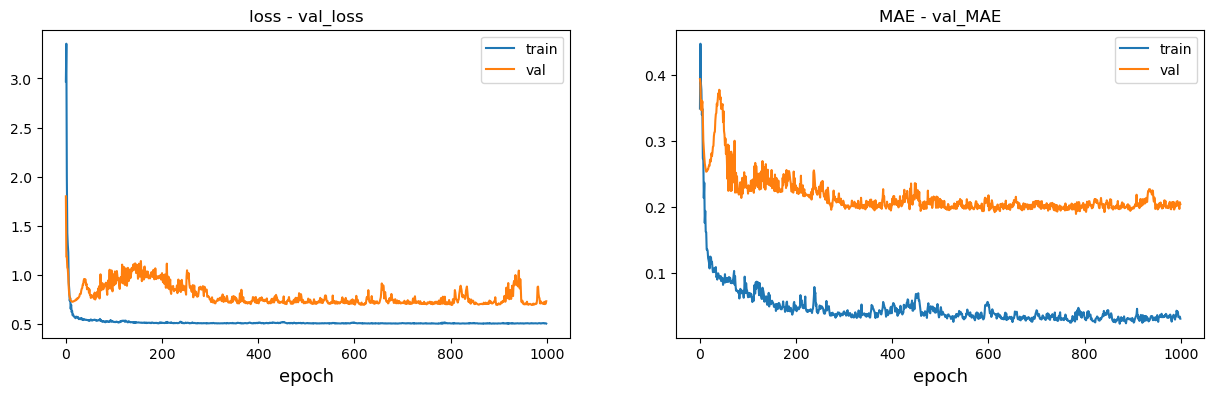

In [23]:
# plotting the history of training
fig, axis = plt.subplots(1, 2, figsize=(15, 4))

axis[0].plot(history.history["loss"], label="train")
axis[0].plot(history.history["val_loss"], label="val")
axis[0].set_title("loss - val_loss")
axis[0].set_xlabel("epoch", fontsize=13)
axis[0].legend(bbox_to_anchor=(1.0, 1.0))


axis[1].plot(history.history["MSE"], label="train")
axis[1].plot(history.history["val_MSE"], label="val")
axis[1].set_title("MSE - val_MSE")
axis[1].set_xlabel("epoch", fontsize=13)
axis[1].legend(bbox_to_anchor=(1.0, 1.0))


plt.show()

In [23]:
# feel free to change these params
size = np.array([800, 800]) # size of output image
i = 40 # index of an image from my data


while True:
    img_real = cv.resize(data[i][0], size, interpolation=cv.INTER_LINEAR)
    img_pred_tmp = data[i][0]
    

    pred = np.array(model_grid_rotation.predict(img_pred_tmp[None] / 255)).flatten()    

    # rotate images
    center_pred = np.array(pred[:2]) * size
    angle_pred = pred[-1] * 360
    
    center_real = np.array(data[i][1][:2]) * size
    angle_real = data[i][1][-1] * 360
    
    rotation_matrix_pred = cv.getRotationMatrix2D(center_pred, angle_pred, scale=1.0)
    rotation_matrix_real = cv.getRotationMatrix2D(center_real, angle_real, scale=1.0)


    img_pred = cv.warpAffine(img_real, rotation_matrix_pred, (img_real.shape[1], img_real.shape[0]))

    img_real = cv.warpAffine(img_real, rotation_matrix_real, (img_real.shape[1], img_real.shape[0]))
    
    
    # show one image rotated with labels and one with predictions
    cv.imshow("IMG_pred (press q to quit)", img_pred)
    cv.imshow("IMG (press q to quit)", img_real)
    

    if cv.waitKey(20) & 0xFF == ord("q"):
        break

cv.destroyAllWindows()

1/1 [==============================] - 0s 16ms/step


QObject::moveToThread: Current thread (0x63dea80) is not the object's thread (0x910c750).
Cannot move to target thread (0x63dea80)

QObject::moveToThread: Current thread (0x63dea80) is not the object's thread (0x910c750).
Cannot move to target thread (0x63dea80)

QObject::moveToThread: Current thread (0x63dea80) is not the object's thread (0x910c750).
Cannot move to target thread (0x63dea80)

QObject::moveToThread: Current thread (0x63dea80) is not the object's thread (0x910c750).
Cannot move to target thread (0x63dea80)

QObject::moveToThread: Current thread (0x63dea80) is not the object's thread (0x910c750).
Cannot move to target thread (0x63dea80)

QObject::moveToThread: Current thread (0x63dea80) is not the object's thread (0x910c750).
Cannot move to target thread (0x63dea80)

QObject::moveToThread: Current thread (0x63dea80) is not the object's thread (0x910c750).
Cannot move to target thread (0x63dea80)

QObject::moveToThread: Current thread (0x63dea80) is not the object's thread

1/1 [==============================] - 0s 17ms/step


### I have managed to get some interesting cases where my predictions were wrong according to my labels but actually also were right but it rotated the image to another diraction. So I needed more strict rules to annotate the data to get my model perform better.

In [32]:
for i in range(len(data)):
    img = data[i][0]
   
    center_real = np.array(data[i][1][:2]) * 150
    angle_real = data[i][1][-1] * 360
    
    rotation_matrix_real = cv.getRotationMatrix2D(center_real, angle_real, scale=1.0)

    img = cv.warpAffine(img, rotation_matrix_real, (img.shape[1], img.shape[0]))
    
    cv.imwrite(os.path.join("my_data/rot_images/", f"{i}_rot.jpg"), img)

### here I created rotated images from my data to annotate and make new csv file where will eventually be my bounding boxes for "X" and "O"